# Machine Learning with dislib

This tutorial will show the different algorithms available in [dislib](https://dislib.bsc.es).

## Requirements

Apart from dislib, this notebook requires [PyCOMPSs 2.5 or higher](https://www.bsc.es/research-and-development/software-and-apps/software-list/comp-superscalar/).


## Setup


First, we need to start an interactive PyCOMPSs session:

In [1]:
import pycompss.interactive as ipycompss
import os
if 'BINDER_SERVICE_HOST' in os.environ:
    ipycompss.start(graph=True,
                    project_xml='../xml/project.xml',
                    resources_xml='../xml/resources.xml')
else:
    ipycompss.start(graph=True, monitor=1000)

******************************************************
*************** PyCOMPSs Interactive *****************
******************************************************
*          .-~~-.--.           _____          __     *
*         :         )         |____ \        / /     *
*   .~ ~ -.\       /.- ~~ .     ___) |      / /__    *
*   >       `.   .'       <    / ___/      /  _  \   *
*  (         .- -.         )  | |___   _  |  |_|  )  *
*   `- -.-~  `- -'  ~-.- -'   |_____| |_|  \_____/   *
*     (        :        )           _ _ .-:          *
*      ~--.    :    .--~        .-~  .-~  }          *
*          ~-.-^-.-~ \_      .~  .-~   .~            *
*                   \ \ '     \ '_ _ -~              *
*                    \`.\`.    //                    *
*           . - ~ ~-.__\`.\`-.//                     *
*       .-~   . - ~  }~ ~ ~-.~-.                     *
*     .' .-~      .-~       :/~-.~-./:               *
*    /_~_ _ . - ~                 ~-.~-._            *
*         

Next, we import dislib and we are all set to start working!

In [2]:
import dislib as ds

## Load the MNIST dataset

In [3]:
x, y = ds.load_svmlight_file('/tmp/mnist/mnist', # Download the dataset
                             block_size=(10000, 784), n_features=784, store_sparse=False)

In [4]:
x.shape

(60000, 784)

In [5]:
y.shape

(60000, 1)

In [6]:
y_array = y.collect()
y_array

array([5., 0., 4., ..., 5., 6., 8.])

In [7]:
img = x[0].collect().reshape(28,28)

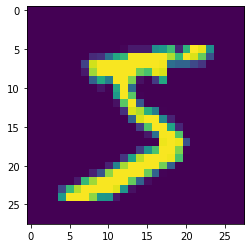

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(img)

In [9]:
int(y[0].collect())

5

## dislib algorithms

### Preprocessing

In [10]:
from dislib.preprocessing import StandardScaler
from dislib.decomposition import PCA

### Clustering

In [11]:
from dislib.cluster import KMeans
from dislib.cluster import DBSCAN
from dislib.cluster import GaussianMixture

### Classification

In [12]:
from dislib.classification import CascadeSVM
from dislib.classification import RandomForestClassifier

### Recommendation

In [13]:
from dislib.recommendation import ALS

### Model selection

In [14]:
from dislib.model_selection import GridSearchCV

### Others

In [15]:
from dislib.regression import LinearRegression
from dislib.neighbors import NearestNeighbors

## Examples
### KMeans

In [16]:
kmeans = KMeans(n_clusters=10)
pred_clusters = kmeans.fit_predict(x).collect()

Get the number of images of each class in the cluster 0:

In [17]:
from collections import Counter
Counter(y_array[pred_clusters==0])

Counter({3.0: 3870,
         9.0: 87,
         2.0: 282,
         5.0: 1783,
         8.0: 1078,
         0.0: 170,
         6.0: 29,
         7.0: 4,
         1.0: 5,
         4.0: 3})

### GaussianMixture

Fit the GaussianMixture with the painted pixels of a single image:

In [18]:
import numpy as np
img_filtered_pixels = np.stack([np.array([i, j]) for i in range(28) for j in range(28) if img[i,j] > 10])
img_pixels = ds.array(img_filtered_pixels, block_size=(50,2))
gm = GaussianMixture(n_components=7, random_state=0)
gm.fit(img_pixels)

Get the parameters that define the Gaussian components:

In [19]:
from pycompss.api.api import compss_wait_on
means = compss_wait_on(gm.means_)
covariances = compss_wait_on(gm.covariances_)
weights = compss_wait_on(gm.weights_)

Use the Gaussian mixture model to sample random pixels replicating the original distribution:

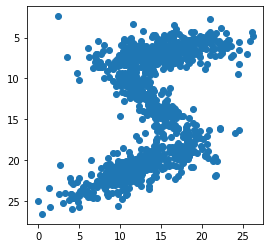

In [20]:
samples = np.concatenate([np.random.multivariate_normal(means[i], covariances[i], int(weights[i]*1000))
                    for i in range(7)])
plt.scatter(samples[:,1], samples[:,0])
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
plt.draw()

### PCA

In [21]:
pca = PCA()
pca.fit(x)

PCA(arity=50, n_components=None)

Calculate the explained variance of the 10 first eigenvectors:

In [22]:
sum(pca.explained_variance_[0:10])/sum(pca.explained_variance_)

0.4881498035493399

Show the weights of the first eigenvector:

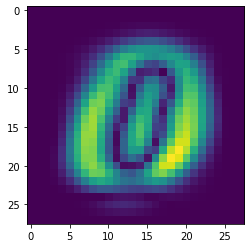

In [23]:
plt.imshow(np.abs(pca.components_[0]).reshape(28,28))

### RandomForestClassifier

In [24]:
rf = RandomForestClassifier(n_estimators=5, max_depth=3)
rf.fit(x, y)

RandomForestClassifier(distr_depth='auto', hard_vote=False, max_depth=3,
                       n_estimators=5, random_state=None,
                       sklearn_max=100000000.0, try_features='sqrt')

Use the test dataset to get an accuracy score:

In [25]:
x_test, y_test = ds.load_svmlight_file('/tmp/mnist/mnist.test', block_size=(10000, 784), n_features=784, store_sparse=False)
score = rf.score(x_test, y_test)
print(compss_wait_on(score))

0.654


### GridSearchCV

Grid Search with Cross-Validation (5-fold) and 4 different combinations of parameters:

In [26]:
parameters = {'n_estimators': (5, 10),
              'max_depth': range(3, 5)}
gs = GridSearchCV(rf, parameters, cv=5)
gs.fit(x,y)

Explore the results:

In [27]:
import pandas as pd
pd_df = pd.DataFrame.from_dict(gs.cv_results_)
print(pd_df[['params', 'mean_test_score']])

                                 params  mean_test_score
0   {'max_depth': 3, 'n_estimators': 5}         0.610817
1  {'max_depth': 3, 'n_estimators': 10}         0.669933
2   {'max_depth': 4, 'n_estimators': 5}         0.695333
3  {'max_depth': 4, 'n_estimators': 10}         0.750983


The estimator with the best results has been refitted on the whole dataset:

In [28]:
gs.best_estimator_

RandomForestClassifier(distr_depth='auto', hard_vote=False, max_depth=4,
                       n_estimators=10, random_state=None,
                       sklearn_max=100000000.0, try_features='sqrt')

Get the accuracy score of the best estimator:

In [29]:
score = gs.best_estimator_.score(x_test, y_test)
print(compss_wait_on(score))

0.7651


### Close the session

To finish the session, we need to stop PyCOMPSs:

In [30]:
ipycompss.stop()

****************************************************
*************** STOPPING PyCOMPSs ******************
****************************************************
         have not been brought to the master.
****************************************************
